In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as special
import matplotlib

In [2]:
#setting matplotlib ticksize
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

#set matplotlib global font size
matplotlib.rcParams['font.size']=20

In [3]:
MeanSeeing = 1 # standard deviation of atmospheric seeing [arcsecond]

I0 = 100 # maximum intensity of Airy disk [counts/second]

def Airy1D(q):
    return I0 * (2 * special.j1(2 * q) / q ) ** 2

# 2D Airy Disk
def AiryDisk(x):

    q = np.sqrt( x[0]**2 + x[1]**2 )

    return I0 * (2 * special.j1(2 * q) / q ) ** 2
    
# doing the MCMC sampling
def get_MCMC_sample(x):

    p_x = [ np.random.normal(x[0], MeanSeeing) ,\
            np.random.normal(x[1], MeanSeeing) ]
    
    # since sigma is the same, the ratio between
    # gaussian probabilities is just 1
    acceptance_prob = min( 1, AiryDisk(p_x) / AiryDisk(x) )
    R = np.random.uniform()

    if R <= acceptance_prob:
        return p_x
    else:
        return x

# MCMC sampling for the Airy Disk
def sampleAiry(Nsamp, Nburn=0, Nskip=0):
    
    #initial x and y

    x = [1, 1]

    # burning off Nburn samples
    for n in range(Nburn):
        x = get_MCMC_sample(x)
        
    samples = []

    # generating our samples
    for n in range(Nsamp):
        
        # skipping every Nburn value
        for i in range(Nburn):

            x = get_MCMC_sample(x)


        x = get_MCMC_sample(x)
        
        samples.append(x)

    return samples

In [4]:
positions = sampleAiry(10000, Nburn=1000, Nskip=5)

In [5]:
positions = np.array(positions)

In [6]:
pos0 = positions[:, 0]
pos1 = positions[:, 1]

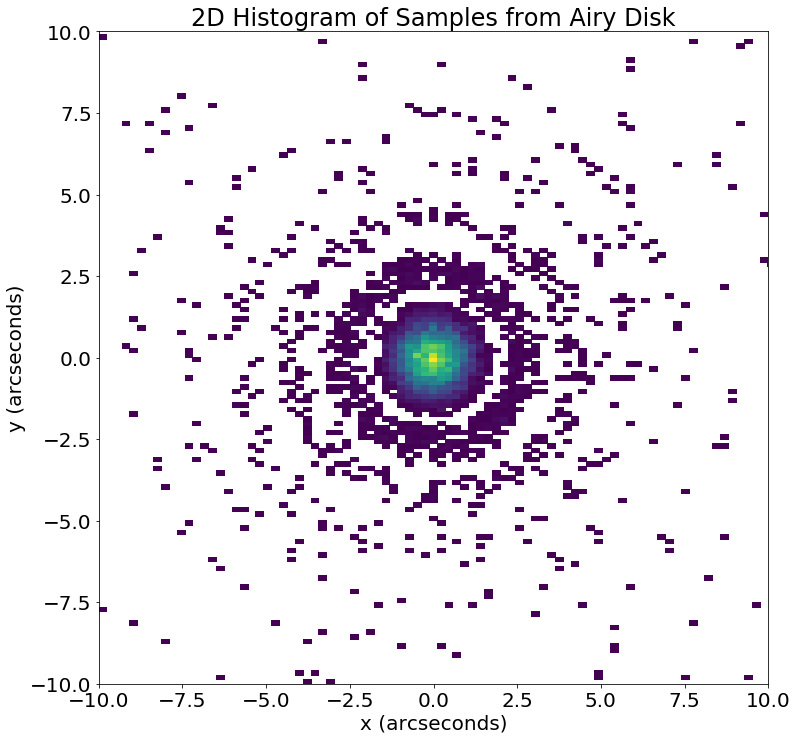

In [7]:
plt.figure(figsize=[12,12])
plt.hist2d(pos0, pos1, bins=1000, cmin=1)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.title('2D Histogram of Samples from Airy Disk')
plt.xlabel('x (arcseconds)')
plt.ylabel('y (arcseconds)')
plt.savefig('AiryDisk.png')
plt.show()

In [8]:
ints = AiryDisk([pos0, pos1])

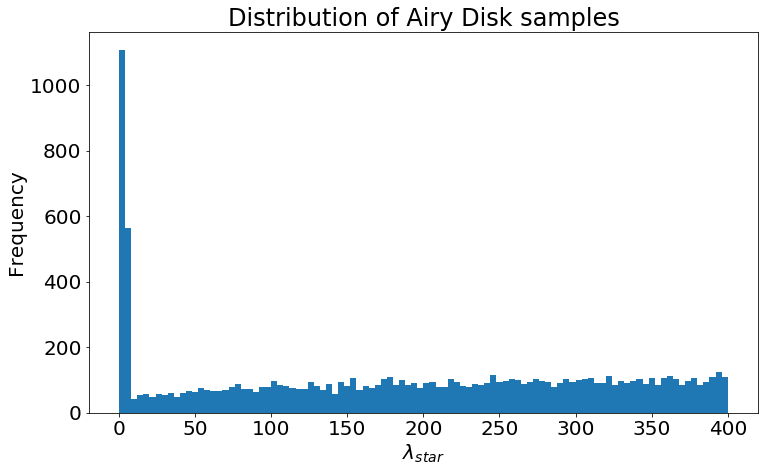

In [9]:
plt.figure(figsize=[12,7])
plt.hist(ints, bins=100)
plt.title('Distribution of Airy Disk samples')
plt.xlabel('$\lambda_{star}$')
plt.ylabel('Frequency')
plt.savefig('Airysamps.png')
plt.show()

In [31]:
# global variables
kB = 8.617333e-5 # [ev/k]

Ef = 1.12 / 2 # band gap of Si divided by 2 [eV]

Nelectrons = 1000 # no. free electrons per pixel

# returns the probability of finding an excited electron
# at energy E [eV] and temperature T [K]
def FermiDirac(E, T):
    return 1/( 1 + np.exp( (E - Ef)/ (kB * T) ) )


# number of noise electrons we measure
# are the number of electrons above the
# Fermi level, so we can do numerical
# integration
def sampleFermiDirac(Nsample, T, n=100):
    
    samples = []
    
    # do the integration here
    
    # lower bound is Ef
    a = Ef

    # upper bound is 1

    b = 1

    V = b - a

    int_samples = []

    xi = np.random.uniform(a, b, size=n)

    int_samples.append( FermiDirac(xi, T) )
    
    # this is the probability of being detected
    integral = (V/n) * np.sum(int_samples)
    
    for i in range(Nsample):

        # generate Nelectrons uniformly random numbers
        nums = np.random.uniform(size=Nelectrons)

        # number of noise electrons
        rate = np.sum( nums <= integral )
        
        samples.append(rate)

    return samples

In [46]:
FDsamples = sampleFermiDirac(10000, 77)

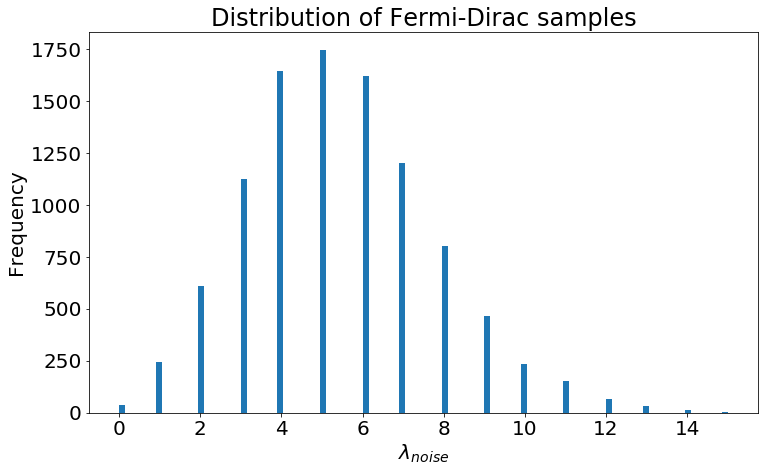

In [47]:
plt.figure(figsize=[12,7])
plt.hist(FDsamples, bins=100)
plt.title('Distribution of Fermi-Dirac samples')
plt.xlabel('$\lambda_{noise}$')
plt.ylabel('Frequency')
plt.savefig('FDsamps.png')
plt.show()